In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('/content/drive/MyDrive/woc files/classification_train.csv')

In [4]:

x_train=np.array(df.iloc[:,2:])
y_train=np.array(df.iloc[:,1])
print(x_train.shape)
print(y_train.shape)
print(x_train)
print(y_train)


(30000, 784)
(30000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[8 4 1 ... 9 4 6]


In [5]:
mu=np.mean(x_train,axis=0)
sigma=np.std(x_train,axis=0)
x_train_norm=((x_train-mu)/sigma)

fu=3000
x_train_train=x_train_norm[fu:,:]
x_test=x_train_norm[:fu,:]
y_train_train=y_train[fu:]
y_test=y_train[:fu]


Xt = x_train_train
m,n=Xt.shape
Yt = np.reshape(y_train_train,(m,1))
print(Xt.shape)

(27000, 784)


In [6]:

o=np.unique(y_train_train)#types of output
l=len(o)#no of tyoes of output
Yt=np.reshape(np.arange(m,dtype=int),(m,1))
for i in range(l):
  ta=y_train_train==o[i]
  Yt[ta]=int(i)

print(o)


[0 1 2 3 4 5 6 7 8 9]


In [7]:

ls=[n,200,100,l]
lss=len(ls)-1
RW=[]
RB=[]
for i in range(lss):
  RW.append(np.random.randn(ls[i],ls[i+1])*(np.sqrt(2/ls[i])))
  RB.append(np.random.randn(1,ls[i+1]))

In [8]:
def Z(X,W,B):#z is function/model
  m,n=X.shape
  z1= np.matmul(X,W)+B
  return z1
def relu(X,W,B,kp):
  m,n=X.shape
  r12=Z(X,W,B)
  r13=r12<0
  r12[r13]=0
  idrop=np.random.rand(r12.shape[0],r12.shape[1])>kp
  r12[idrop]=0
  r12=r12/kp
  return r12
def Ac(X,W,B):
  m,n=X.shape
  ez=np.exp(Z(X,W,B))
  s=np.reshape(np.sum(ez,axis=1),(m,1))
  a111=ez/s
  return a111
def FP(X,W,B,kp):
  m,n=X.shape
  a=[X]
  for i in range(lss-1):
    a.append(relu(a[i],W[i],B[i],kp))
  a.append(Ac(a[lss-1],W[lss-1],B[lss-1]))
  return(a)
  

In [9]:
At=FP(Xt,RW,RB,1)
print(At[-1])

[[0.00051737 0.04243194 0.00577911 ... 0.00109192 0.00081533 0.03029955]
 [0.00103088 0.04728412 0.00869896 ... 0.00058724 0.00161823 0.0056757 ]
 [0.00149419 0.08578802 0.00295027 ... 0.00711412 0.00038369 0.09015567]
 ...
 [0.00177374 0.10186397 0.00370987 ... 0.00357182 0.01483793 0.0016262 ]
 [0.01304746 0.1391962  0.01571533 ... 0.05120018 0.00107548 0.10614346]
 [0.00040921 0.23636916 0.00204041 ... 0.00128071 0.00111428 0.0011113 ]]


In [10]:
Ijt=np.zeros(At[-1].shape)
Ijt[np.arange(m),np.reshape(Yt,m)]=1

In [11]:
def c(A,Y,W,lam):
  m=Y.shape[0]
  loss=np.log(A[-1][np.arange(m),np.reshape(Y,m)])
  regs=0
  for i in range(lss):
    regs= regs+((np.sum(W[i])/(2*m))*lam)
  c1=np.sum((-1*loss/m))+regs
  return c1
print(c(At,Yt,RW,0.1))

4.122423134248426


In [12]:
def Derivatives(X,Y,A,W,B,Ij,lam): 
  m,n=X.shape
  dj_da=[0]*lss
  dB=[0]*lss
  dW=[0]*lss
  dj_da[-1]=((A[-1]-Ij)/m)
  dB[-1]=np.sum(dj_da[-1],axis=0)
  dW[-1]=np.matmul(A[-2].T,dj_da[-1])+((lam/m)*W[-1])
  for i in range(lss-2,-1,-1):
    dj_da[i]=np.matmul(dj_da[i+1],W[i+1].T)
    temz1=A[i+1]==0
    dj_da[i][temz1]=0
    dB[i]=np.sum(dj_da[i],axis=0)
    dW[i]=np.matmul(A[i].T,dj_da[i])+((lam/m)*W[i])
  return dW,dB



def p(X,W,B): #pridiction
  m,n=X.shape
  y4=FP(X,W,B,1)
  y5=np.argmax(y4[-1],axis=1)
  return y5

print(p(Xt,RW,RB))


[6 6 5 ... 6 5 6]


In [13]:
def g(X,Y,W,B,alo,dr,it,lam,bs,kp): #g is gradiant
  m,n=X.shape
  c_log=np.zeros(it)
  Ij=np.zeros((m,ls[-1]))
  Ij[np.arange(m),np.reshape(Y,m)]=1
  VdW=[0]*lss
  VdB=[0]*lss
  SdW=[0]*lss
  SdB=[0]*lss
  VdWc=[0]*lss
  VdBc=[0]*lss
  SdWc=[0]*lss
  SdBc=[0]*lss
  bsr=(m//bs)+1
  t=0
  for i in range(it):
    al=(1/(1+(dr*i)))*alo
    for k in range(bsr):
      Xmb=X[(bs*k):(bs*(k+1)),:]
      Ymb=Y[(bs*k):(bs*(k+1)),:]
      Ijmb=Ij[(bs*k):(bs*(k+1)),:]
      Amb=FP(Xmb,W,B,kp)
      dW,dB = Derivatives(Xmb,Ymb,Amb,W,B,Ijmb,lam)
      t=t+1
      for j in range(lss):
        VdW[j]=(0.9*VdW[j])+((0.1)*dW[j])
        VdB[j]=(0.9*VdB[j])+((0.1)*dB[j])
        SdW[j]=(0.999*SdW[j])+((0.001)*(dW[j]**2))
        SdB[j]=(0.999*SdB[j])+((0.001)*(dB[j]**2))
        VdWc[j]=VdW[j]/(1-(0.9**t))
        VdBc[j]=VdB[j]/(1-(0.9**t))
        SdWc[j]=SdW[j]/(1-(0.999**t))
        SdBc[j]=SdB[j]/(1-(0.999**t))
        W[j]=(W[j]-((al*VdWc[j])/(1e-8+(SdWc[j]**(0.5)))))
        B[j]=(B[j]-((al*VdBc[j])/(1e-8+(SdBc[j]**(0.5)))))
    m,n=X.shape
    A=FP(X,W,B,1)
    c_log[i]=c(A,Y,W,lam)
    print('',end='.')
    if (i+1)%10==0:
      print(c_log[i])
      lolo=(p(X,W,B)-np.reshape(Y,m))
      accuracy=(np.count_nonzero(lolo==0)/m)*100
      print('train',accuracy,'%')
      lolo=(p(x_test,W,B)-np.reshape(y_test,x_test.shape[0]))
      accuracy=(np.count_nonzero(lolo==0)/x_test.shape[0])*100
      print('cv',accuracy,'%')
  fig,(ax1,ax2)=plt.subplots(1,2)
  ax1.plot(c_log[:10])
  ax2.plot(10+np.arange(len(c_log[10:])),c_log[10:])
  ax1.set_title("cost vs  iterations")
  ax2.set_title("cost vs  iterations")
  plt.show()
  print(f"i={it},cost={c(A,Y,W,lam)}")
  print(t)
  return W,B


..........0.3184280074879974
train 87.96666666666667 %
cv 86.0 %
..........0.24476667271480848
train 90.72592592592592 %
cv 87.73333333333333 %
..........0.19521006382338216
train 92.80740740740741 %
cv 88.0 %
..........0.15469989081287053
train 94.54074074074073 %
cv 88.3 %
..........0.12497239587040575
train 95.81111111111112 %
cv 88.36666666666667 %
..........0.10487303068418415
train 96.56296296296296 %
cv 87.9 %
....

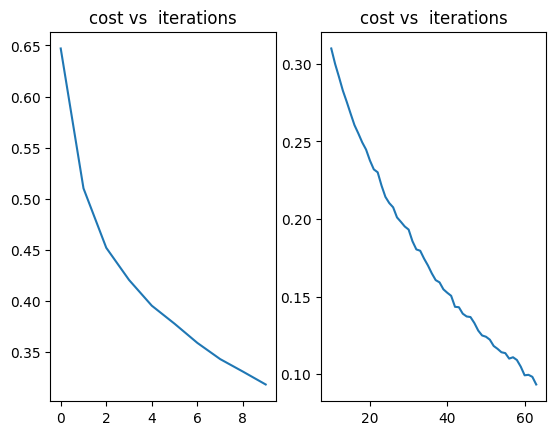

i=64,cost=0.09338290049043307
896


In [14]:
ls=[n,200,100,l]
lss=len(ls)-1
RW=[]
RB=[]
for i in range(lss):
  RW.append(np.random.randn(ls[i],ls[i+1])*(np.sqrt(2/ls[i])))
  RB.append(np.random.randn(1,ls[i+1]))
Wf,Bf= g(Xt,Yt,RW,RB,0.01,0.1,64,0.1,2048,0.8)

In [16]:
lolo=(p(Xt,Wf,Bf)-np.reshape(Yt,m))
print(np.unique(Yt, return_counts=True))
print(np.unique(lolo, return_counts=True))
accuracy=(np.count_nonzero(lolo==0)/m)*100
print(accuracy,'%')

lolo=(p(x_test,Wf,Bf)-np.reshape(y_test,x_test.shape[0]))
print(np.unique(lolo, return_counts=True))
accuracy=(np.count_nonzero(lolo==0)/x_test.shape[0])*100
print(accuracy,'%')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2721, 2692, 2691, 2716, 2681, 2695, 2713, 2692, 2700, 2699]))
(array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  6,  8]), array([  172,     5,    76,    28,   192,    28, 26192,    26,   163,
          26,    31,    57,     4]))
97.00740740740741 %
(array([-8, -6, -4, -3, -2, -1,  0,  1,  2,  3,  4,  6,  8]), array([   2,   37,   30,   24,   67,   19, 2659,   11,   84,   17,   27,
         19,    4]))
88.63333333333333 %


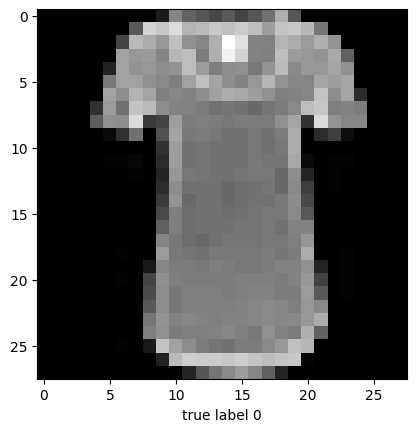

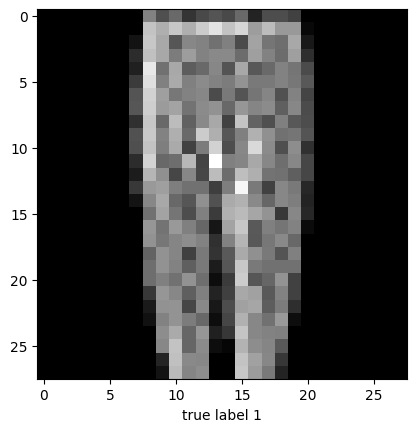

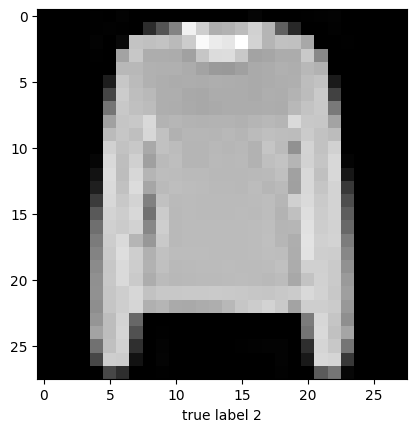

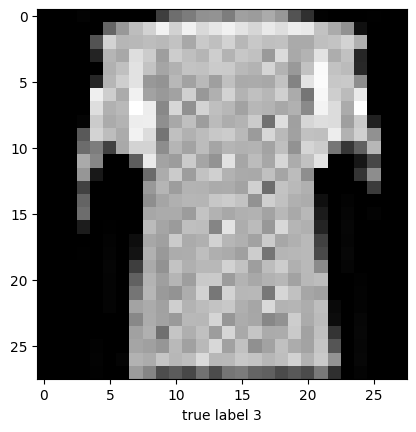

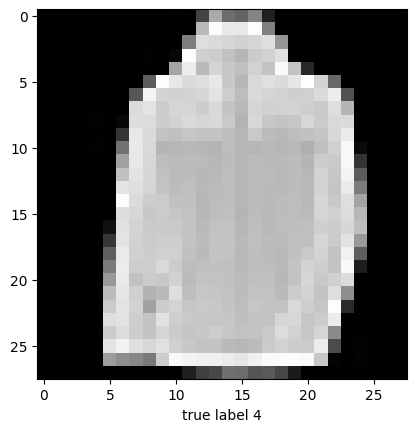

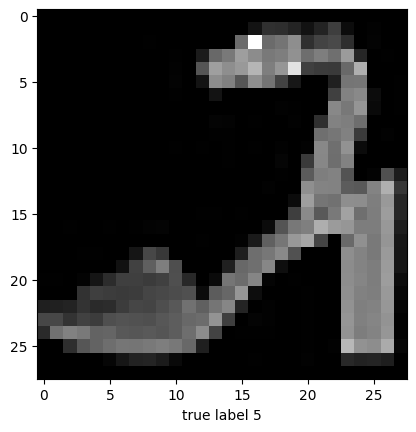

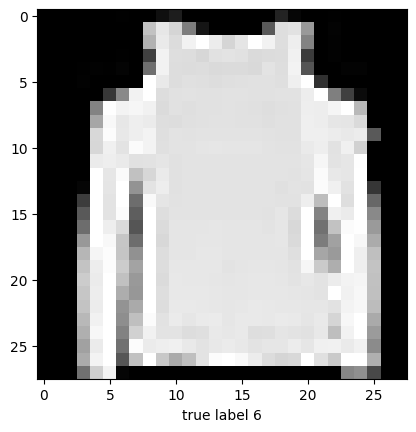

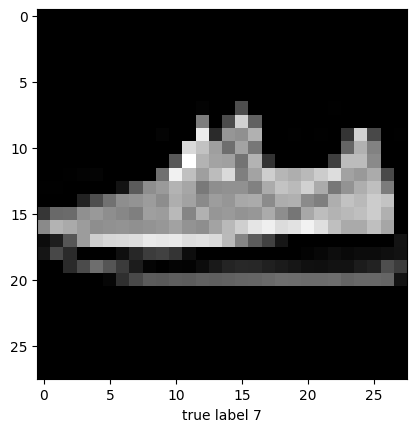

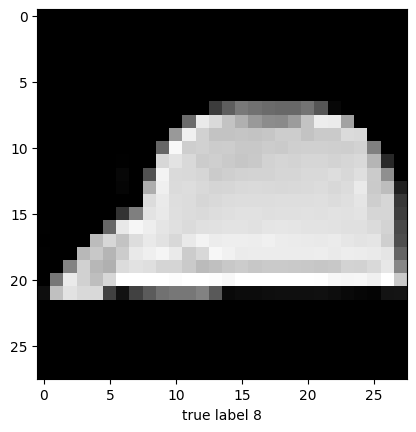

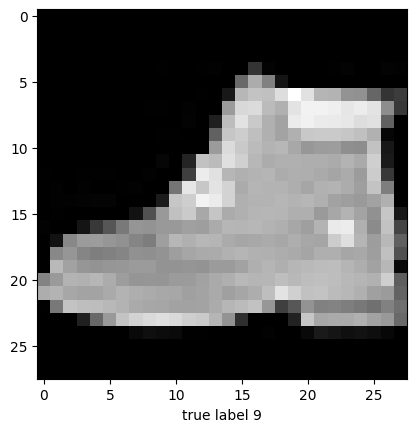

In [31]:
o,u = np.unique(y_train,return_index = True)
for i in u:
  plt.imshow(x_train[i,:].reshape(28,28),cmap = 'gray')
  plt.xlabel(f'true label {y_train[i]}')
  plt.show()

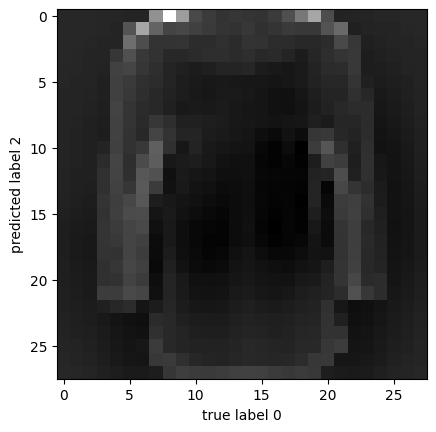

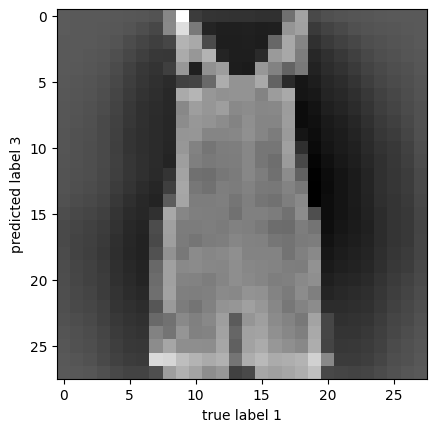

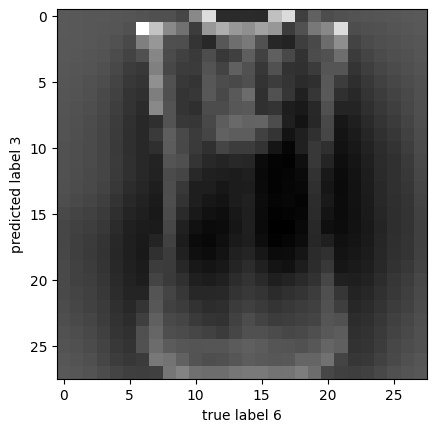

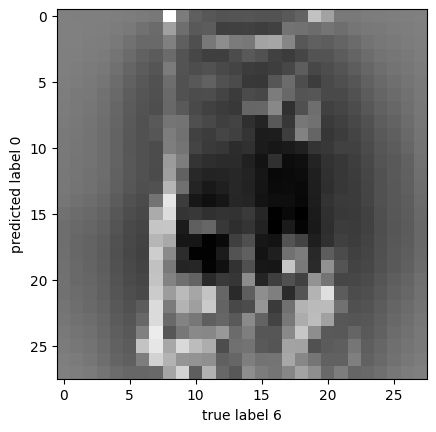

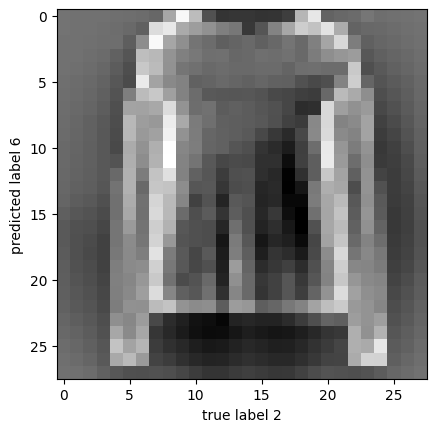

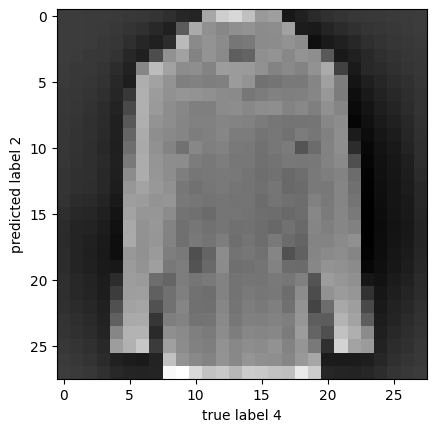

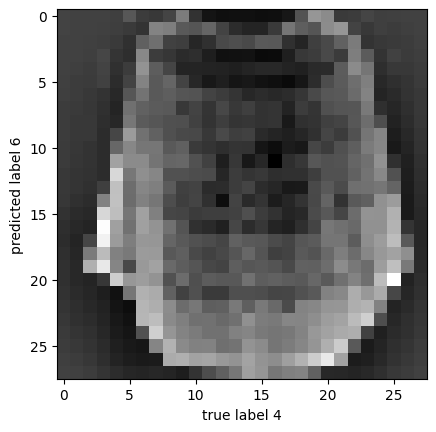

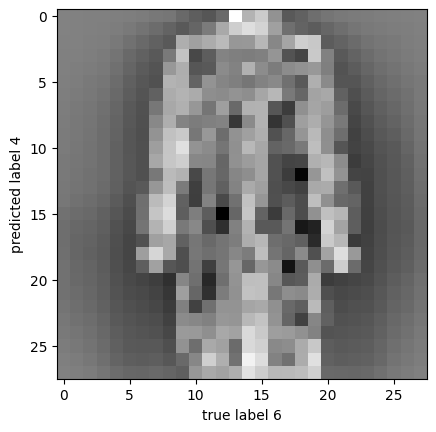

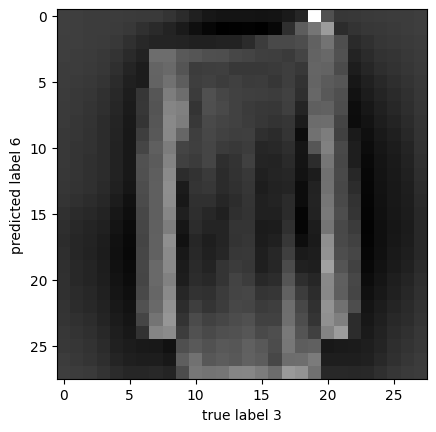

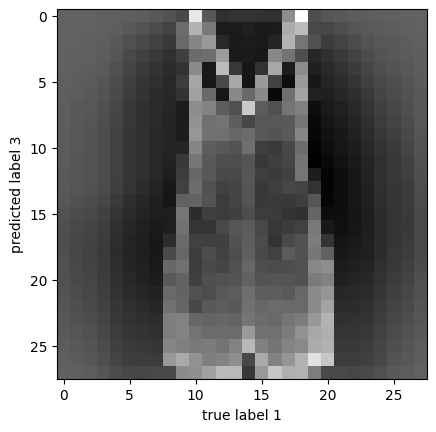

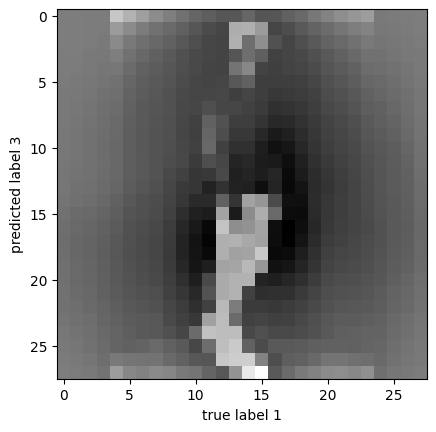

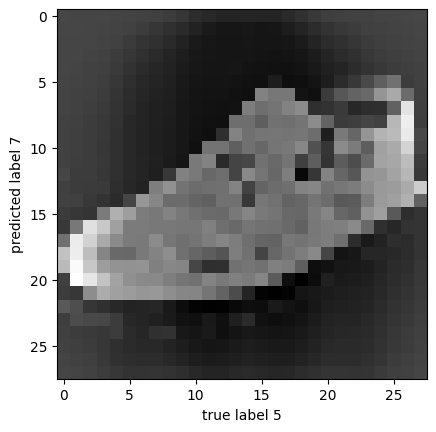

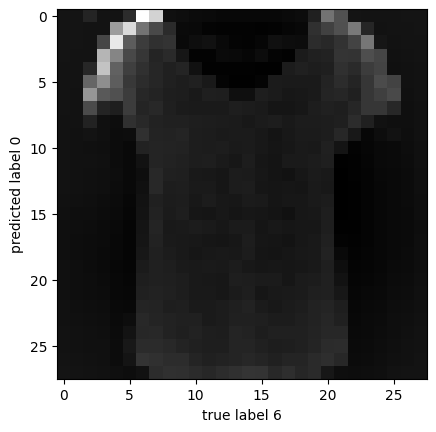

In [30]:

for i in range(100,200):
  if (lolo[i]!=0):
    plt.imshow(x_test[i,:].reshape(28,28),cmap = 'gray')
    plt.xlabel(f'true label {y_test[i]}')
    plt.ylabel(f'predicted label {p(x_test,Wf,Bf)[i]}')
    plt.show()